In [1]:
import opendp.prelude as dp

In [140]:
dp.enable_features("contrib","honest-but-curious")

In [3]:
privacy_unit= dp.unit_of(contributions=1)

In [4]:
privacy_loss=dp.loss_of(epsilon=1.0)

In [5]:
# pip install urllib

In [6]:
import urllib.request
data_url="https://raw.githubusercontent.com/opendp/opendp/sydney/teacher_survey.csv"
with urllib.request.urlopen(data_url) as f:
    data=f.read().decode("utf-8")

context=dp.Context.compositor(
    data=data,
    privacy_unit=privacy_unit,
    privacy_loss=privacy_loss,
    split_evenly_over=3
)

In [7]:
col_names=[
    "names","sex","age","maritalStatus","hasChildren","highestEducationLevel","sourceOfStress","smoker","optimism","lifeSatisfaction","selfEsteem"
]

In [8]:
count_query=(
    context.query().split_dataframe(",",col_names=col_names).select_column("age",str).count().laplace()
)

In [9]:
scale=count_query.param()
print(scale)

3.0000000000000004


In [10]:
accuracy=dp.discrete_laplacian_scale_to_accuracy(scale,alpha=0.05)
accuracy

9.445721638273586

In [11]:
dp_count=count_query.release()
dp_count

6999

In [12]:
dp_count-accuracy,dp_count+accuracy

(6989.554278361727, 7008.445721638273)

In [13]:
mean_query=(
    context.query().split_dataframe(",",col_names=col_names).select_column("age",str).cast_default(float).clamp((17.0,70.0)).resize(size=dp_count,constant=42.0).mean().laplace()
)

In [154]:
print(mean_query.param())
print(mean_query.map(1))

0.02271753107710181


AttributeError: Unrecognized constructor: 'map'

In [14]:
mean_query.release()

37.346269479969095

# moving to another dataset

In [103]:
import urllib.request
data_url="https://raw.githubusercontent.com/opendp/opendp/sydney/Sydney_Synth_Pedestrian_Counts_2024_2_3.csv"
with urllib.request.urlopen(data_url) as f:
    data=f.read().decode("utf-8")

In [104]:
privacy_unit=dp.unit_of(contributions=3)

In [105]:
privacy_loss=dp.loss_of(epsilon=1.0)

In [106]:
col_names=["Street","Hour","First Name","Last Name","Age","Gender"]
street_names=["Park Street","Bridge Street", "Market Street"]

In [107]:
context=dp.Context.compositor(
    data=data,
    privacy_unit=privacy_unit,
    privacy_loss=privacy_loss,
    split_evenly_over=10,
)

In [108]:
Bridge_count_query=(
    context.query().split_dataframe(",",col_names=col_names).df_is_equal("Street","Bridge Street").subset_by("Street", keep_columns=["First Name"]).select_column("First Name",str).count().laplace()
)
Bridge_count_query.release()

3848

In [109]:
count_query=(
    context.query().split_dataframe(',',col_names=col_names).select_column("Street",str).count_by_categories(street_names,null_category=False).laplace()
)
street_wise_sighting=count_query.release()
street_wise_sighting

[33781, 3813, 18762]

In [110]:
hours=list(range(24))
hour_count_query=(
    context.query().split_dataframe(",",col_names=col_names).select_column("Hour",str).cast_default(int).count_by_categories(hours,null_category=False).laplace()
)
hourly_sightings= hour_count_query.release()
hourly_sightings

[1864,
 1338,
 1353,
 1245,
 583,
 236,
 398,
 672,
 1020,
 1875,
 2812,
 3734,
 4422,
 4494,
 5045,
 4853,
 4914,
 4100,
 3127,
 2794,
 2047,
 1787,
 1050,
 768]

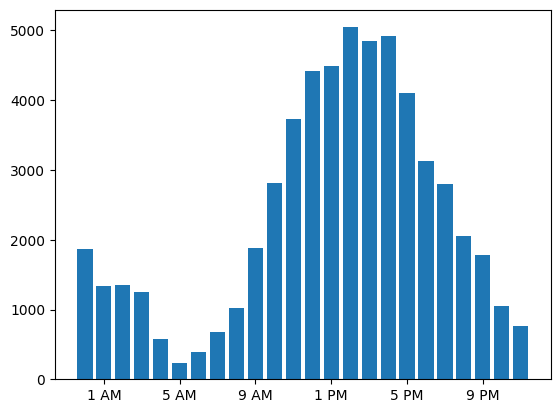

In [111]:
import matplotlib.pyplot as plt

def fmt(hour):
    return f"{int(hour)%12} {'AM' if int(hour)<12 else 'PM'}"

plt.bar(list(map(fmt,hours)),hourly_sightings)
plt.xticks(range(1,24,4))
plt.show()


In [112]:
park_street_ages=(
    context.query().split_dataframe(",",col_names=col_names).df_is_equal("Street","Park Street").select_column("Age",str).cast_default(float).clamp((0.,100.)).resize(size=street_wise_sighting[0],constant=42.0)
)

In [164]:
q_park_street_mean_ages= park_street_ages.sum().laplace()
q_park_street_mean_ages.release()

OpenDPException: 
  FailedFunction("out of queries")

In [161]:
q_park_street_mean_ages= park_street_ages.mean().laplace()
q_park_street_mean_ages.release()

41.438106022508585

In [114]:
q_park_street_variance_ages= park_street_ages.variance().laplace()
q_park_street_variance_ages.release()

188.8251002532894

In [115]:
quantile_query=(
    context.query().split_dataframe(",",col_names=col_names).df_is_equal("Street","Park Street").subset_by("Street",keep_columns=["Age"]).select_column("Age",str).cast_default(int).quantile_score_candidates(list(range(100)),alpha=0.75).report_noisy_max_gumbel(optimize="min")

)
quantile_query.release()

53

In [116]:
quantile_query=(
    context.query().split_dataframe(",",col_names=col_names).df_is_equal("Street","Park Street").subset_by("Street",keep_columns=["First Name"]).select_column("First Name",str).count_by(M0=dp.L1Distance[int]).alp_queryable(scale=.025,total_limit=sum(street_wise_sighting),value_limit=1000)

)
# qbl=quantile_query.release()
# qbl

ValueError: At most one parameter may be missing at a time

In [117]:
qbl("Michael"),qbl("David"),qbl("John")

NameError: name 'qbl' is not defined

# Framework API

In [147]:
input_metric, d_in=privacy_unit
assert d_in==3
assert input_metric == dp.symmetric_distance()
output_metric, d_out=privacy_loss
assert d_out==1
assert output_metric == dp.max_divergence(T=float)

In [148]:
m_sc=dp.c.make_sequential_composition(
    input_domain=dp.atom_domain(T=str),
    input_metric=input_metric,
    output_measure=output_metric,
    d_in=d_in,
    d_mids=[d_out/3]*3,
)
qbl_sc=m_sc(data)

In [149]:
t_count=(
    dp.t.make_split_dataframe(",",col_names=col_names)
    >>dp.t.make_select_column("Street",str)
    >>dp.t.then_count()
)

In [150]:
count_sensetivity= t_count.map(d_in)
count_sensetivity

3

In [152]:
m_count=dp.binary_search_chain(
    lambda scale: t_count>>dp.m.then_laplace(scale=scale), 5, 1/3
)
dp_count=qbl_sc(m_count)
print(dp_count)

56378


In [133]:
t_mean=(
    dp.t.make_split_dataframe(",",col_names=col_names)
    >>dp.t.make_select_column("Age",str)
    >>dp.t.then_cast_default(float)
    >>dp.t.then_clamp((18.,70.))
    >>dp.t.then_resize(size=dp_count,constant=42.0)
    >>dp.t.then_mean()
)



In [135]:
count_sensetivity= m_count.map(d_in)
count_sensetivity

0.33333333333333326

In [134]:
m_mean=dp.binary_search_chain(
    lambda scale: t_mean>>dp.m.then_laplace(scale=scale), d_in, d_out/3
)
mean_release=qbl_sc(m_mean)
print(mean_release)

41.525588584152956


# constructing custom functions

In [144]:
from typing import Tuple
import numpy as np
def make_clamp(bounds: Tuple[int,int]):
    return dp.t.make_user_transformation(
        input_domain=dp.vector_domain(dp.atom_domain(T=int)),
        input_metric=dp.symmetric_distance(),
        output_domain=dp.vector_domain(dp.atom_domain(bounds)),
        output_metric=dp.symmetric_distance(),
        function= lambda x: np.clip(x,*bounds),
        stability_map= lambda d_in: d_in

    )
m_clamp=make_clamp((18,70))
m_clamp([17,18,70,71])

[18, 18, 70, 70]

In [145]:
m_clamp.map(2)

2